# 1.Packages & Data

In [4]:
%cd /content/drive/MyDrive/Machine Learning project/Data

/content/drive/MyDrive/Machine Learning project/Data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

In [36]:
# 데이터 불러오기
df = pd.read_csv("premium.csv")

In [37]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


MetaData
- age : 연령
- sex : 성별
- bmi : 신체
- children : 자녀 수
- smoker : 흡연 여부
- region : 지역
- charges(목표 변수) : 보험료

In [38]:
# 데이터의 모양 알아보기
print(df.shape)

(1338, 7)


In [39]:
# 중복된 항목 확인
print('중복된 항목 수 :', df.duplicated().sum())

중복된 항목 수 : 1


In [40]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [41]:
# 중복된 항목 제거
df.drop_duplicates(inplace=True, keep='first', ignore_index = True)

In [42]:
# 데이터 타입
df.info()
# 결측치 bmi 5개
# 데이터 타입은 잘 되어 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1332 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


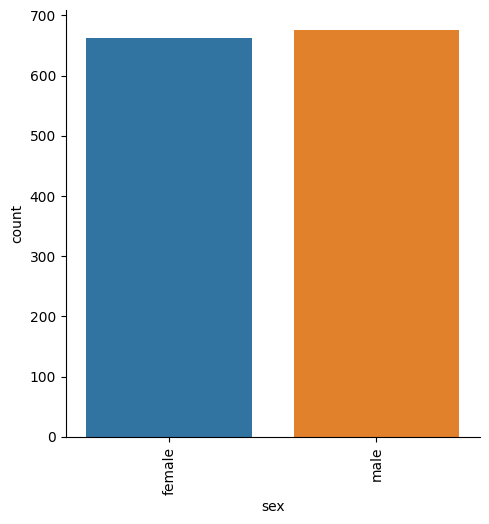

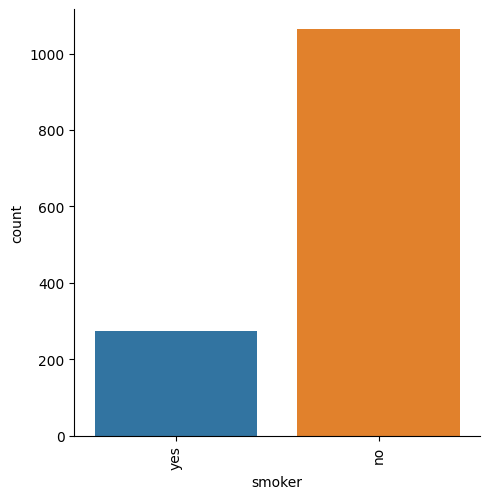

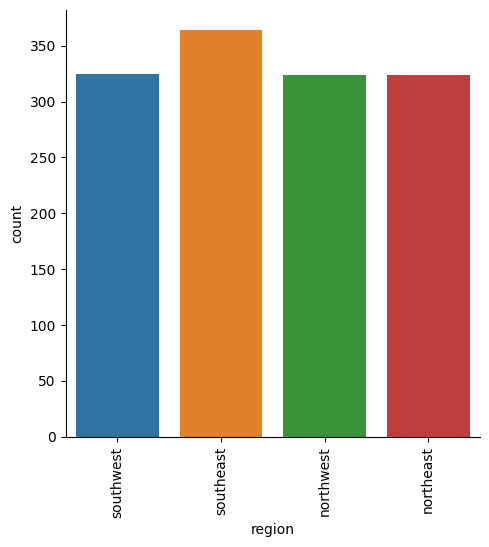

In [43]:
 # 범주형 변수별 개수 시각화
for col in df.select_dtypes(include=['object','category']).columns:
  fig = sns.catplot(x=col, kind="count", data=df, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()
# 여성이 조금 많음
# 흡연 여부는 'no'가 많음
# 서부 지역이 많음

In [44]:
# 성별, 흡연 여부 -> LabelEncoder
# 지역 -> OneHotEncoder

# Label Encoder
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])

# One-Hot Encoding
ohe = OneHotEncoder()
ohe_result = ohe.fit_transform(df[['region']]).toarray()
ohe_df = pd.DataFrame(ohe_result, columns=ohe.get_feature_names_out(['region']))
df = df.join(ohe_df)
# df.drop('region', axis=1, inplace=True)

# # OR pd.get_dummies
# df_dummies = pd.get_dummies(df['region'], prefix='region')
# df = pd.concat([df, df_dummies], axis=1)
# df.drop('region', axis=1, inplace=True)

# 데이터 확인
df.head()

,age,sex,bmi,children,smoker,region,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,southwest,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,northwest,3866.85520,0.0,1.0,0.0,0.0


bmi    5
dtype: int64


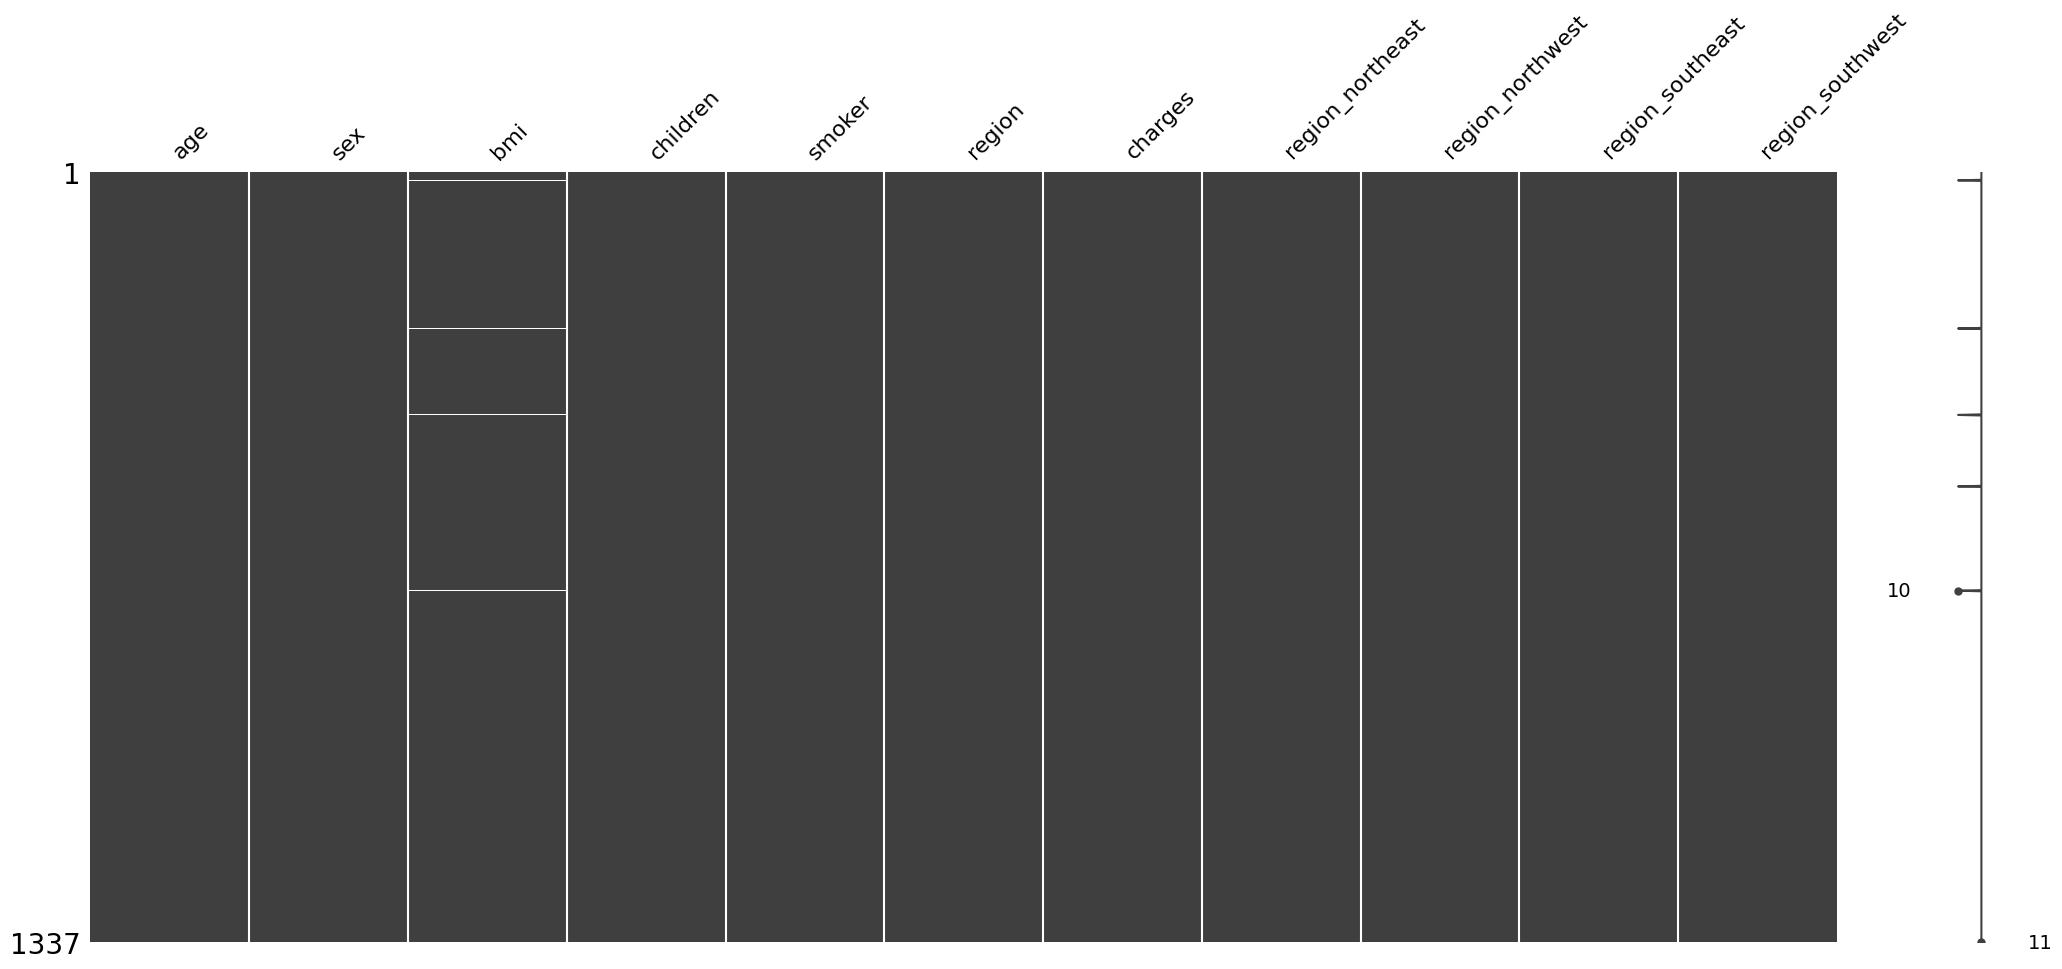

In [45]:
# 결측치 확인
missingno.matrix(df);
print(df.isnull().sum()[df.isnull().sum() > 0]) # bmi 컬럼 5개 결측치

In [46]:
# bmi 결측치 5개에 대한 평균값 대체
df['bmi'].fillna(df['bmi'].mean(), inplace = True)

### 누락된 데이터 유형
- MAR (Missing at Random): 누락된 데이터는 관측된 데이터와 관련이 있으나 누락된 데이터 자체와는 무관합니다.
- MCAR (Missing Completely at Random): 누락된 데이터는 다른 모든 변수와 무관합니다.
- MNAR (Missing Not at Random): 누락된 데이터는 누락된 값 자체나 다른 변수와 관련이 있습니다.

### 누락된 데이터 처리 방법
- 삭제 : 하나 이상의 결측값이 있는 모든 관측치 삭제 -> 편향된 결과를 초래
- 쌍별 삭제 : 가능한 모든 데이터를 사용하여 분석, 서로 다른 변수 조합에 따라 관측치 수가 달라짐
- 변수 삭제 : 60% 이상의 데이터가 누락된 경우, 그리고 변수가 중요하지 않다면 해당 변수 삭제

### 대체 방법
- 평균, 중앙값, 최빈값
- 선형회귀
- 다중 대치

### 범주형 변수
- 범주형 변수 대치 : 로지스틱 회귀, ANOVA등 사용, 편향을 도입할 수 있음
- KNN : 유사한 인스턴스 찾아 누락된 값 대체

### 시계열 데이터에 특화된 방법
- LOCF & NOCB : 누락된 데이터를 앞뒤 데이터로 대체합니다. 추세가 있는 데이터에는 적합하지 않을 수 있음
- 선형 보간법: 누락된 값을 주변 값의 선형적 추세에 따라 채웁니다. 추세가 있는 데이터에 적합
- 계절 조정 후 선형 보간법: 추세와 계절성이 있는 데이터에 적합

In [47]:
# 수치형 변수 이상치 확인
df[['age', 'bmi', 'charges']].describe()

,age,bmi,charges
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.658596,13279.121487
std,14.044333,6.083657,12110.359656
min,18.000000,15.960000,1121.873900
25%,27.000000,26.315000,4746.344000
50%,39.000000,30.400000,9386.161300
75%,51.000000,34.600000,16657.717450
max,64.000000,53.130000,63770.428010


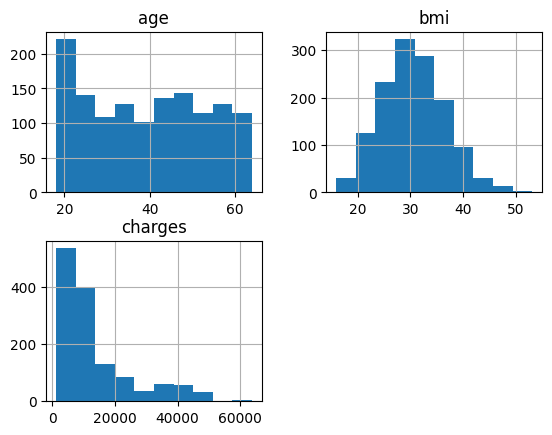

In [48]:
# 수치형 변수 히스토그램
df[['age', 'bmi', 'charges']].hist()
plt.show()

In [35]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

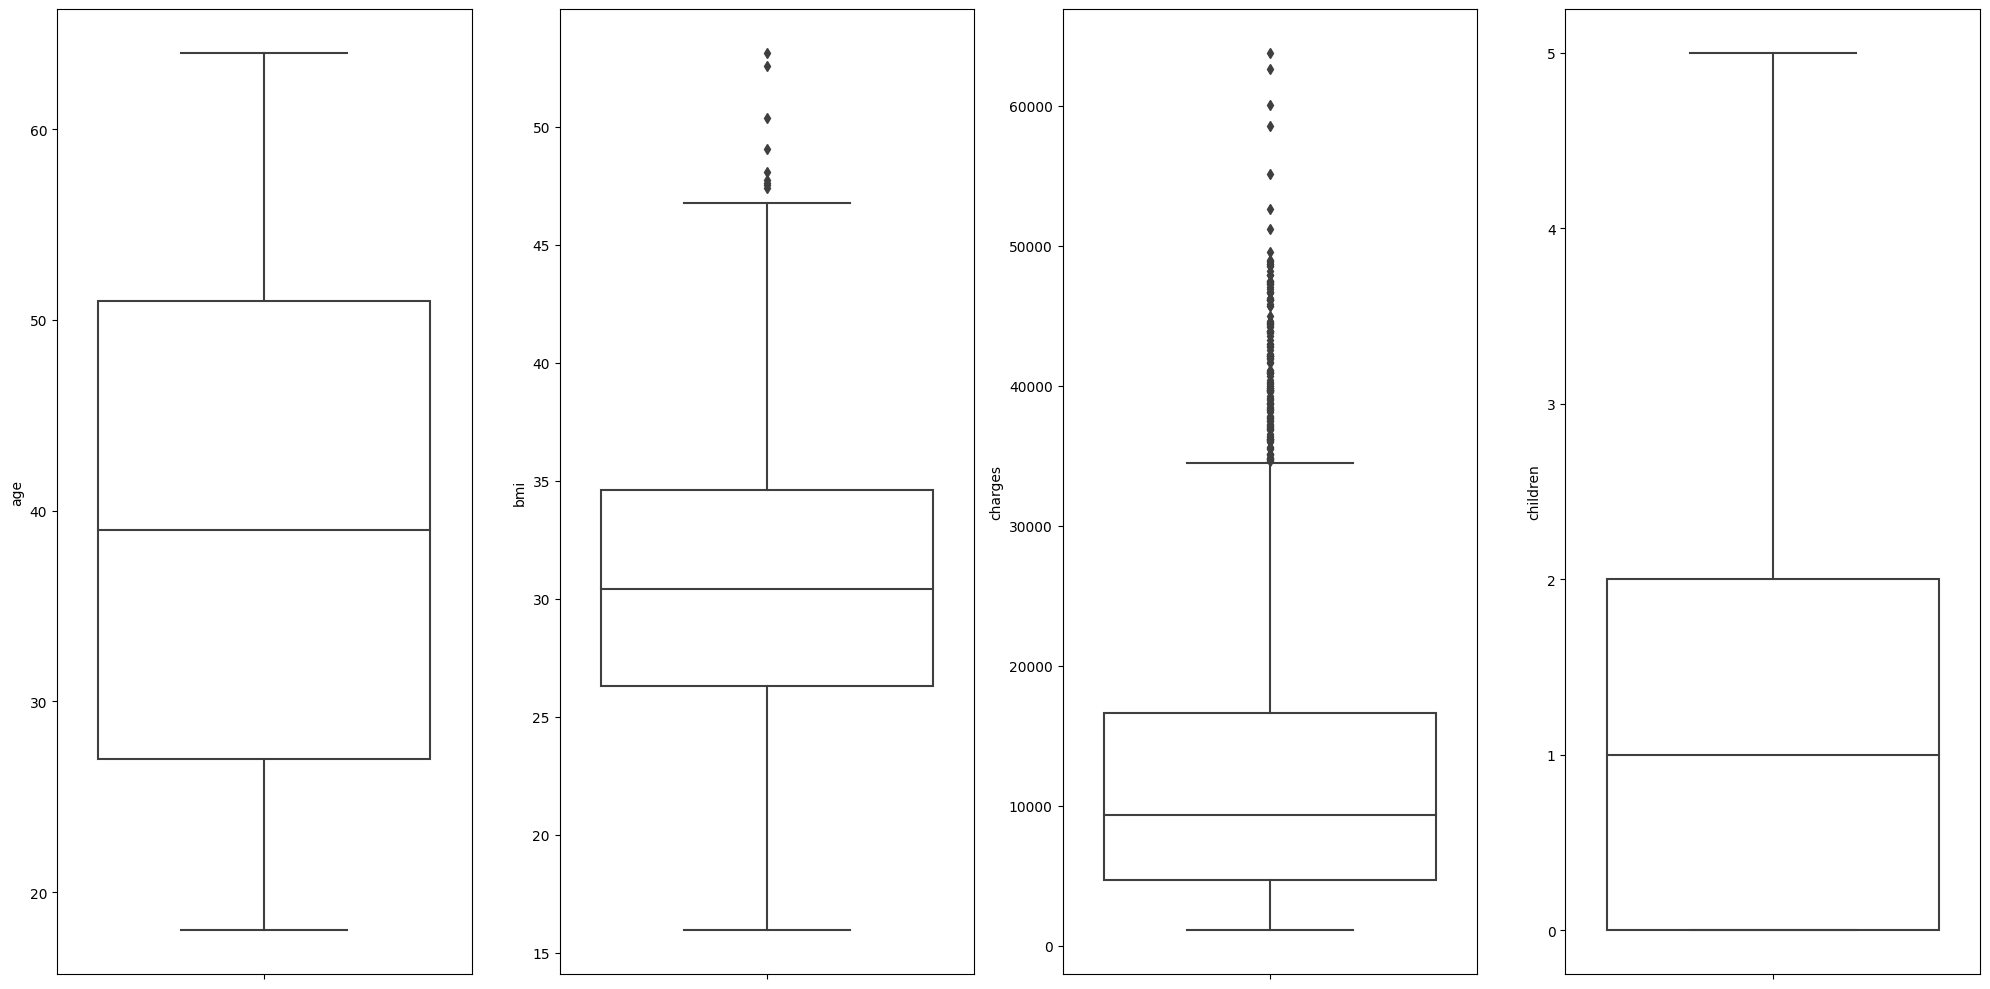

In [61]:
# 수치형 박스플롯
columns = df[['age','bmi','charges','children']].columns
figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    if index > 0:
        figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
figure.tight_layout()
plt.show()
# bmi, charges는 이상치 존재

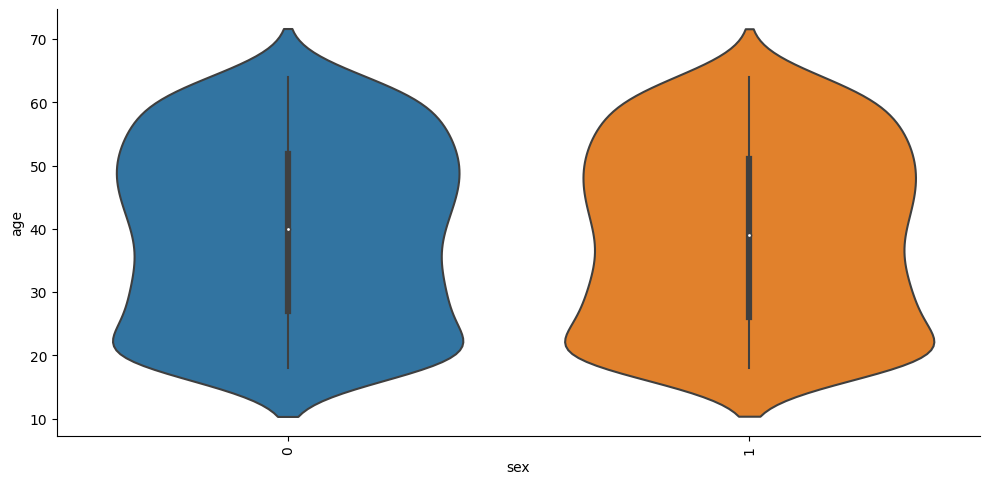

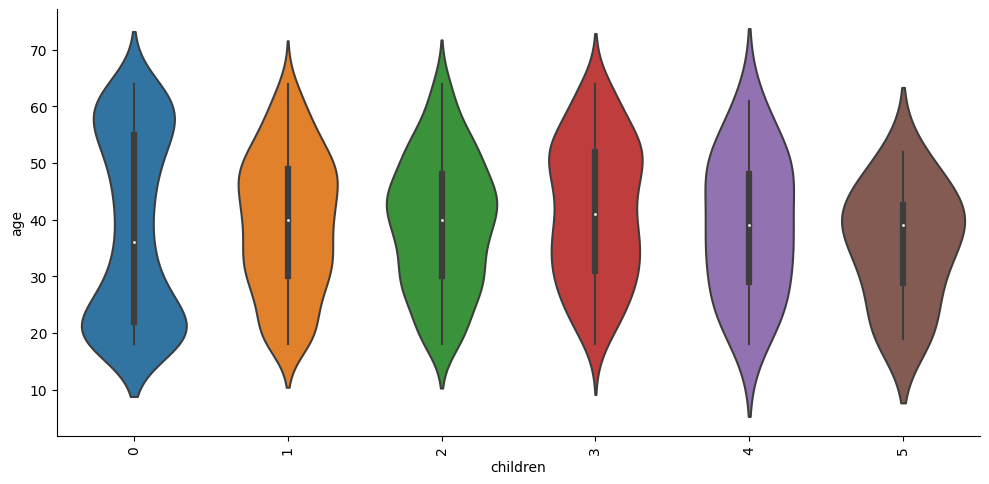

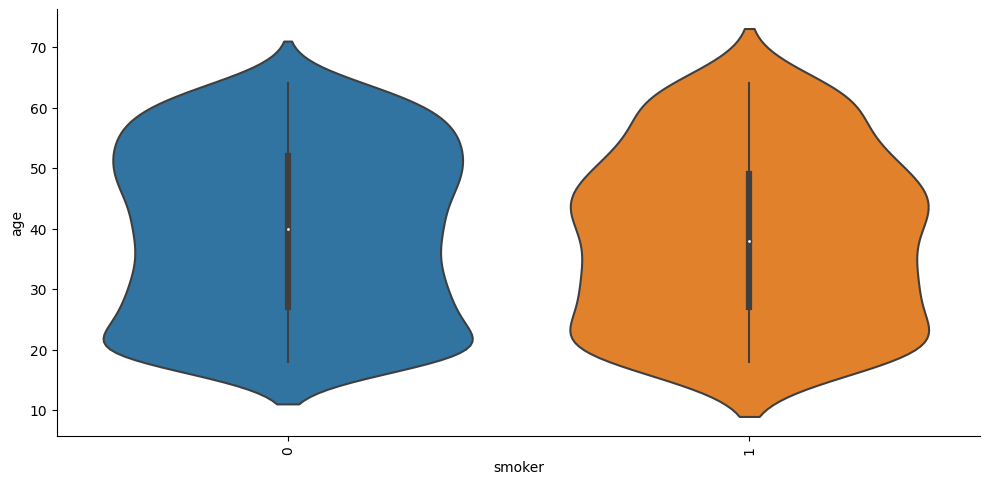

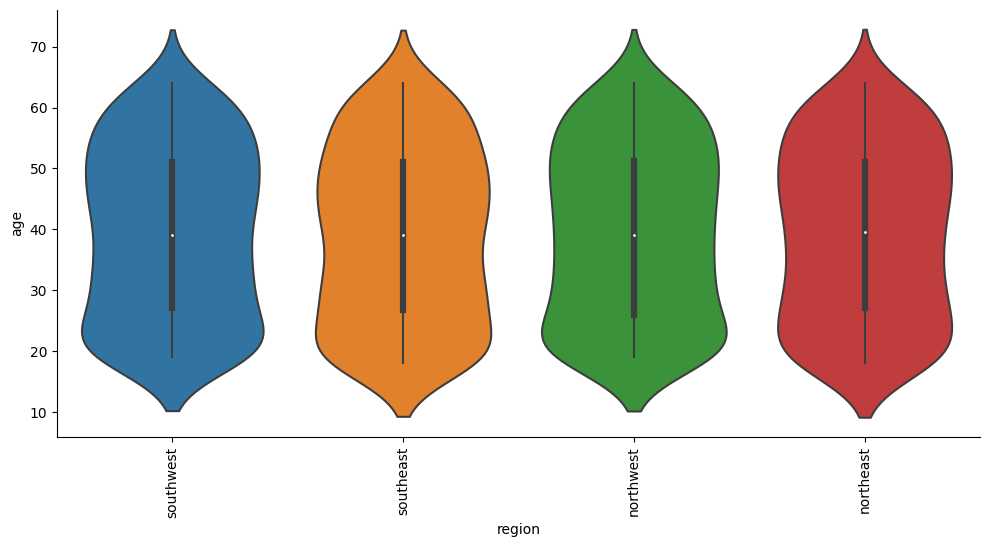

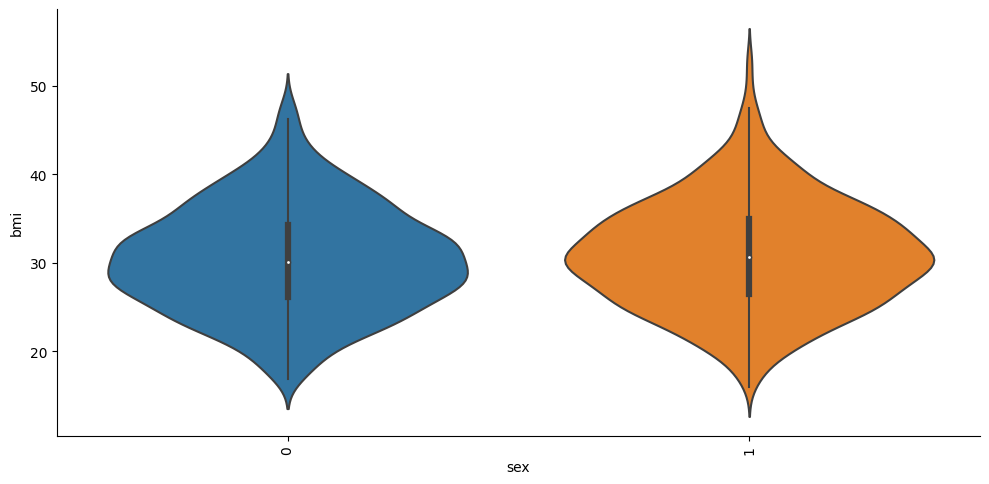

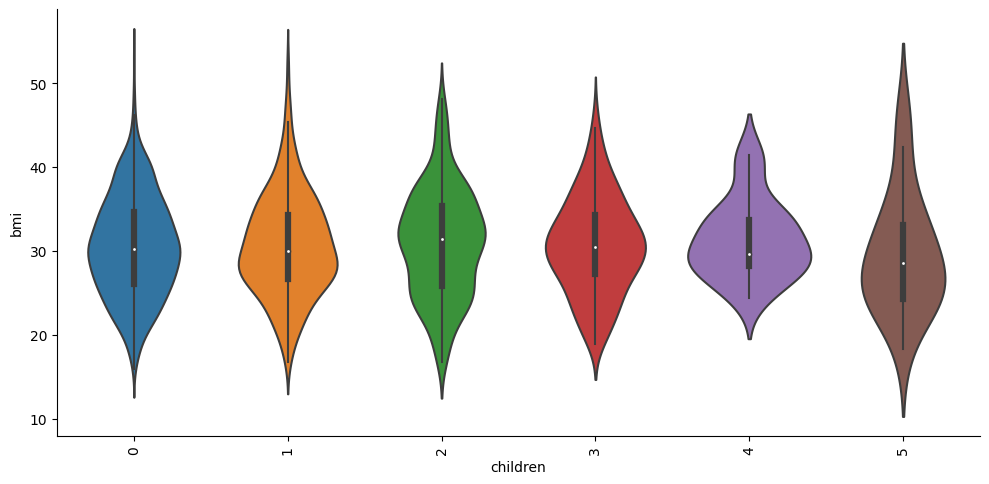

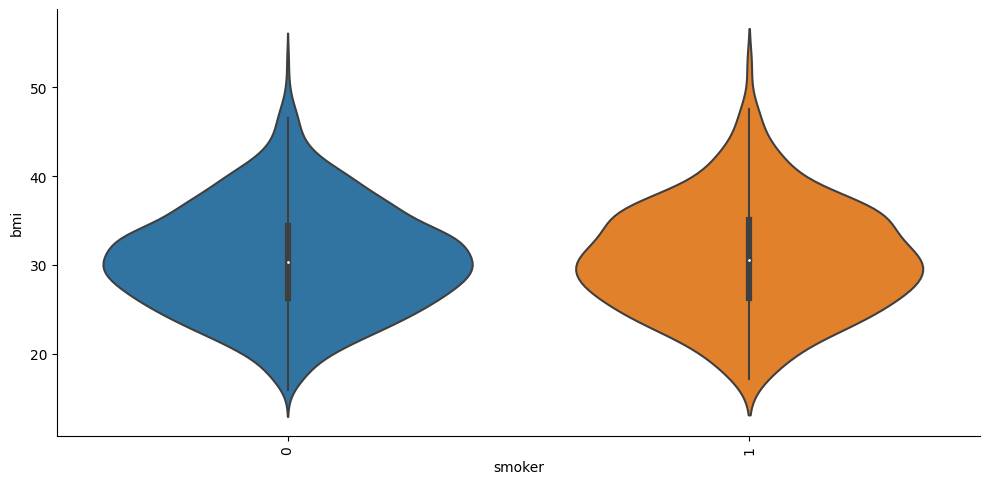

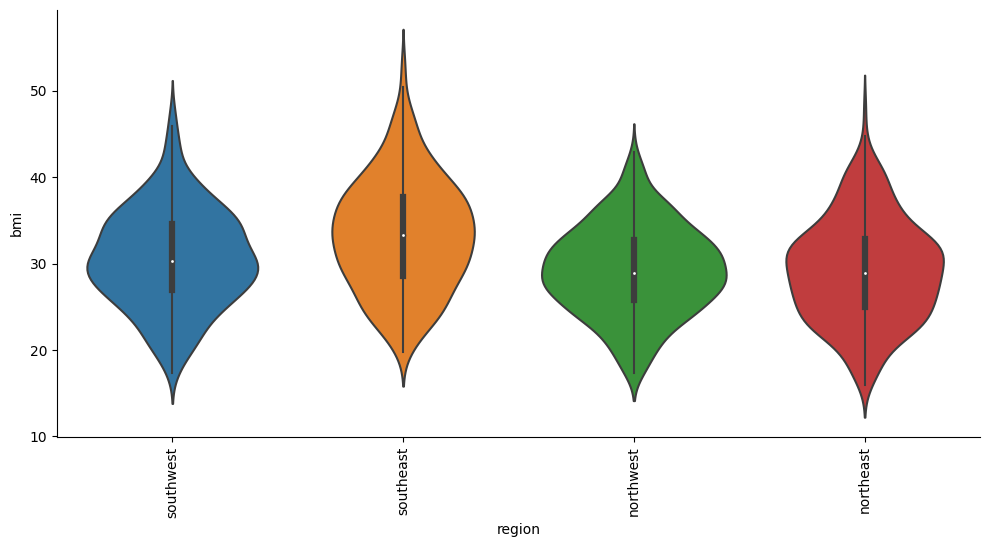

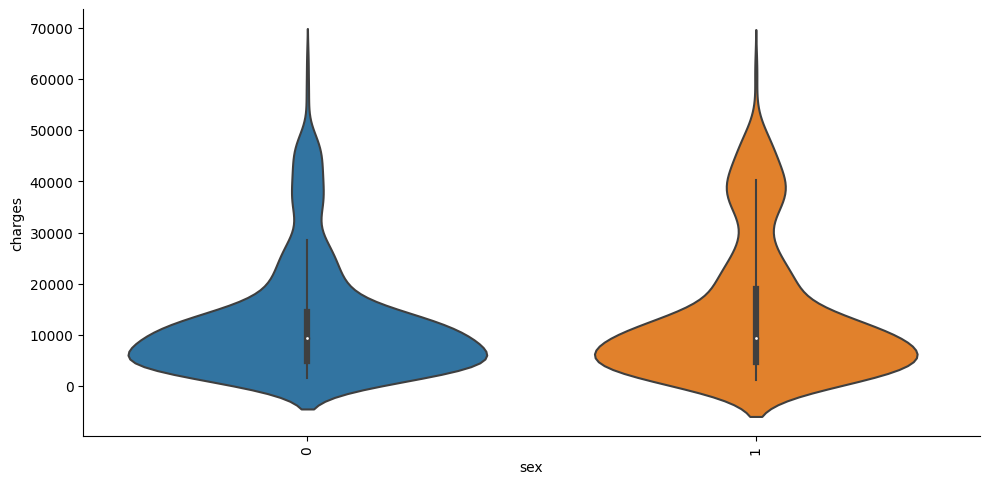

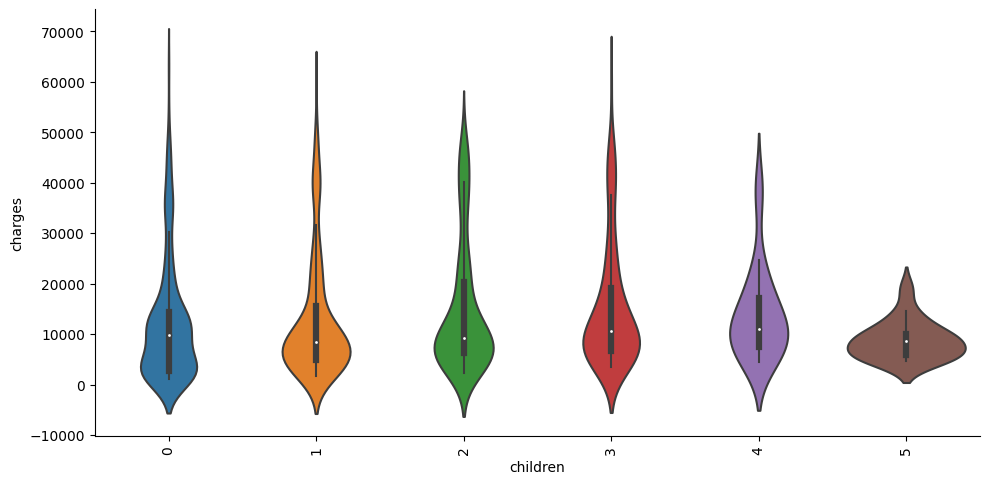

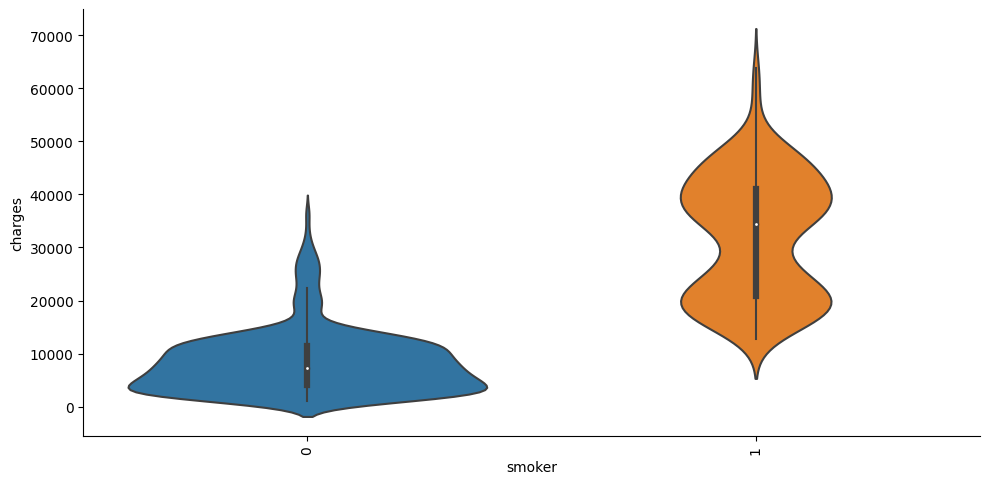

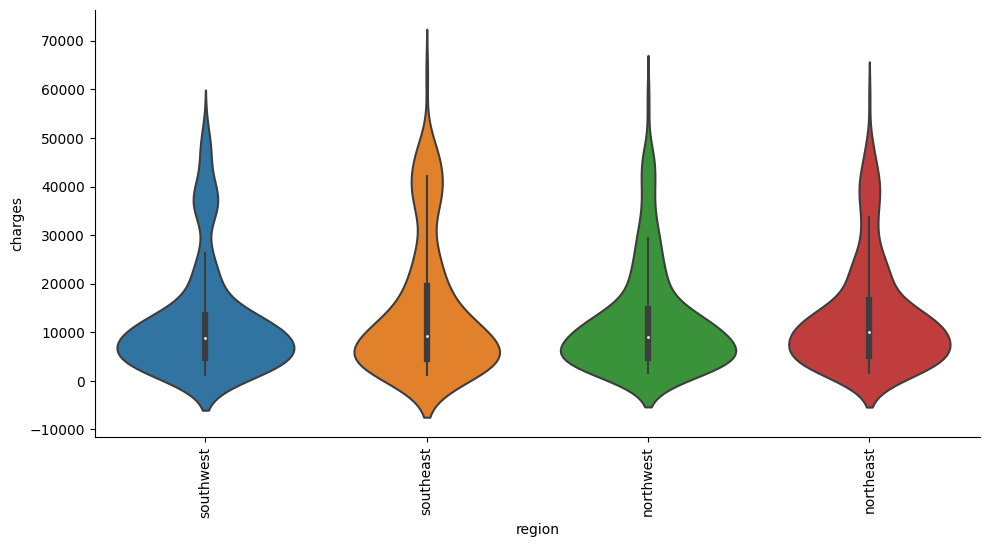

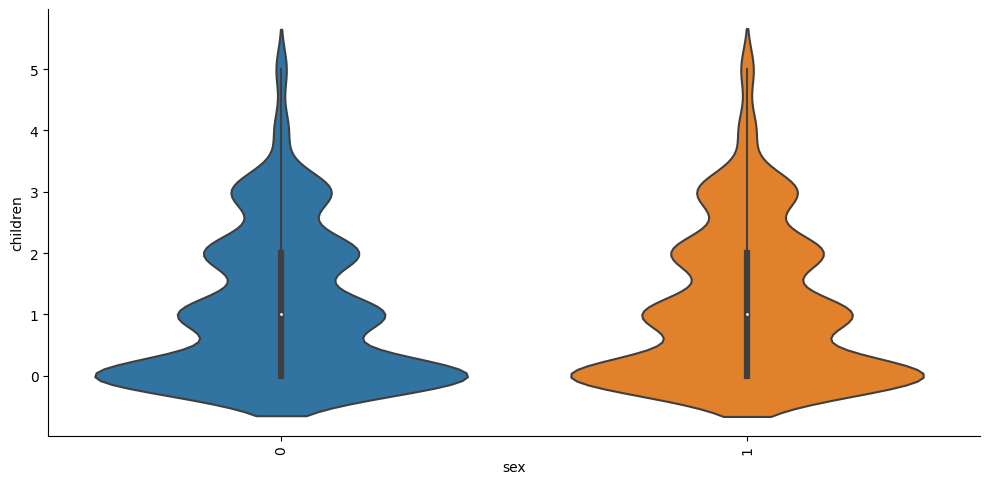

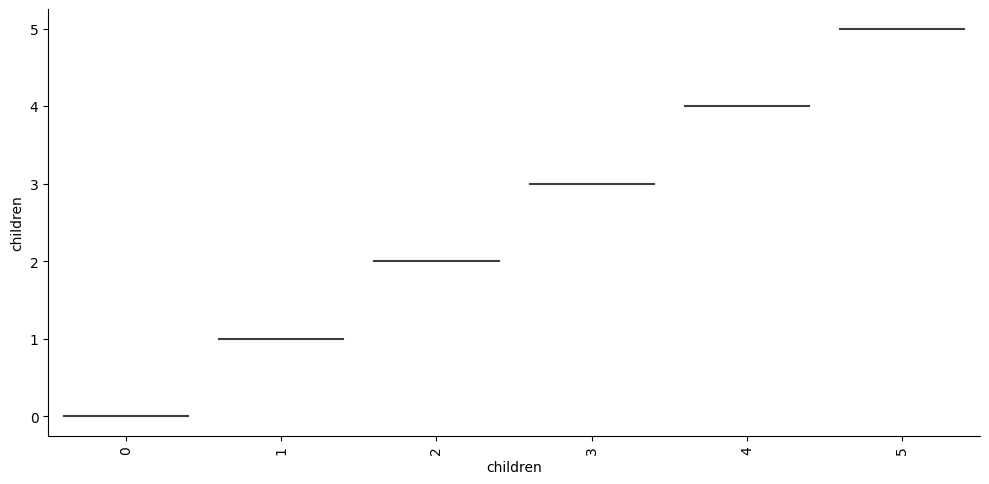

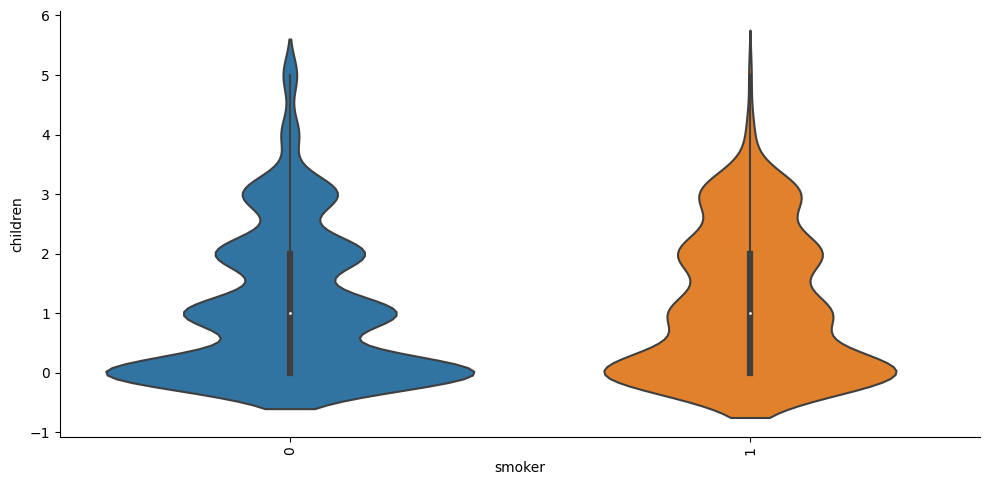

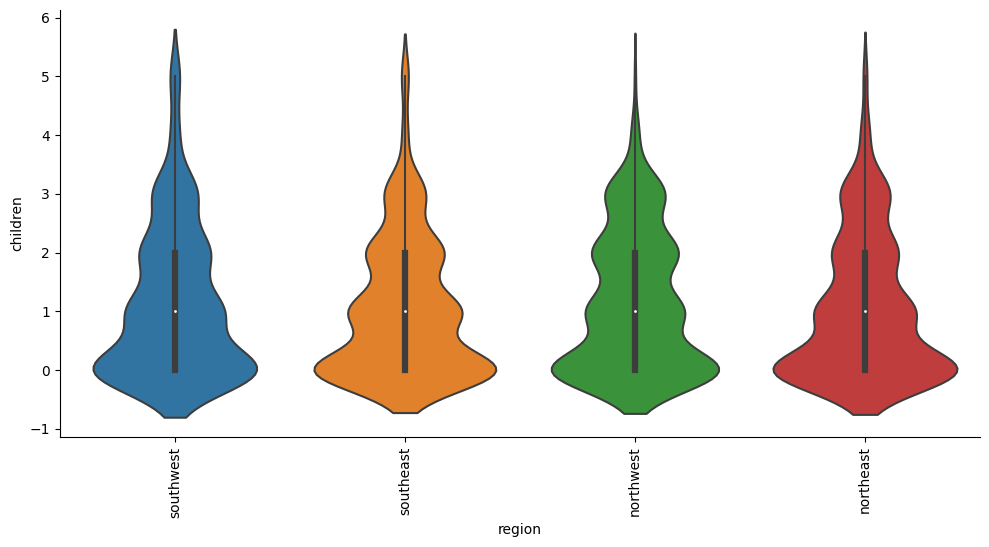

In [63]:
if len(df.select_dtypes(include=['object','category']).columns) > 0:
        for col_num in columns:
            for col in ['sex', 'children', 'smoker', 'region']:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()

<Axes: >

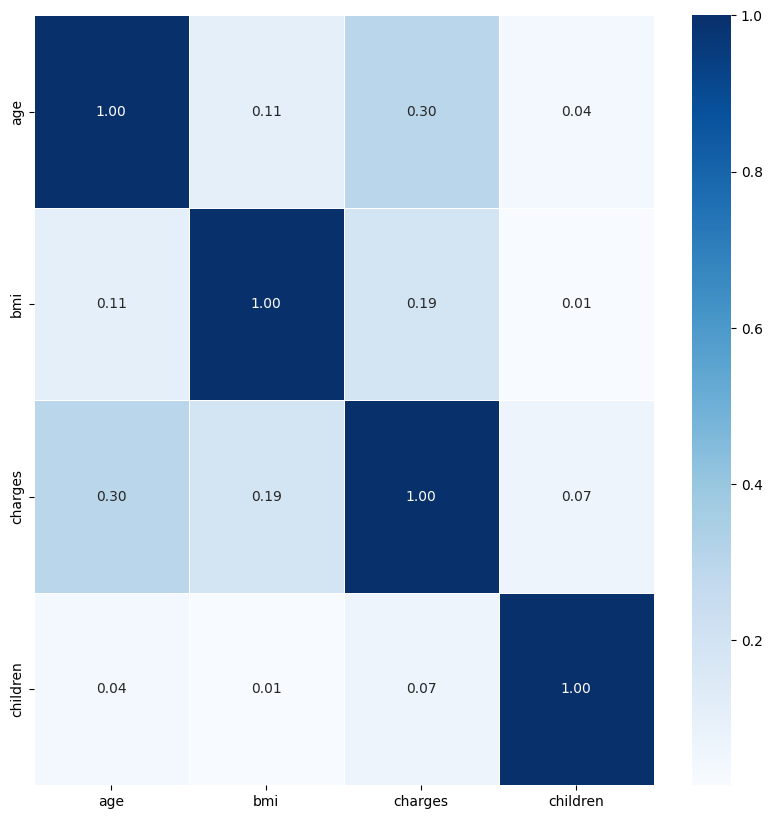

In [64]:
# 변수간 상관관계
plt.figure(figsize=(10, 10))
sns.heatmap(df[columns].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

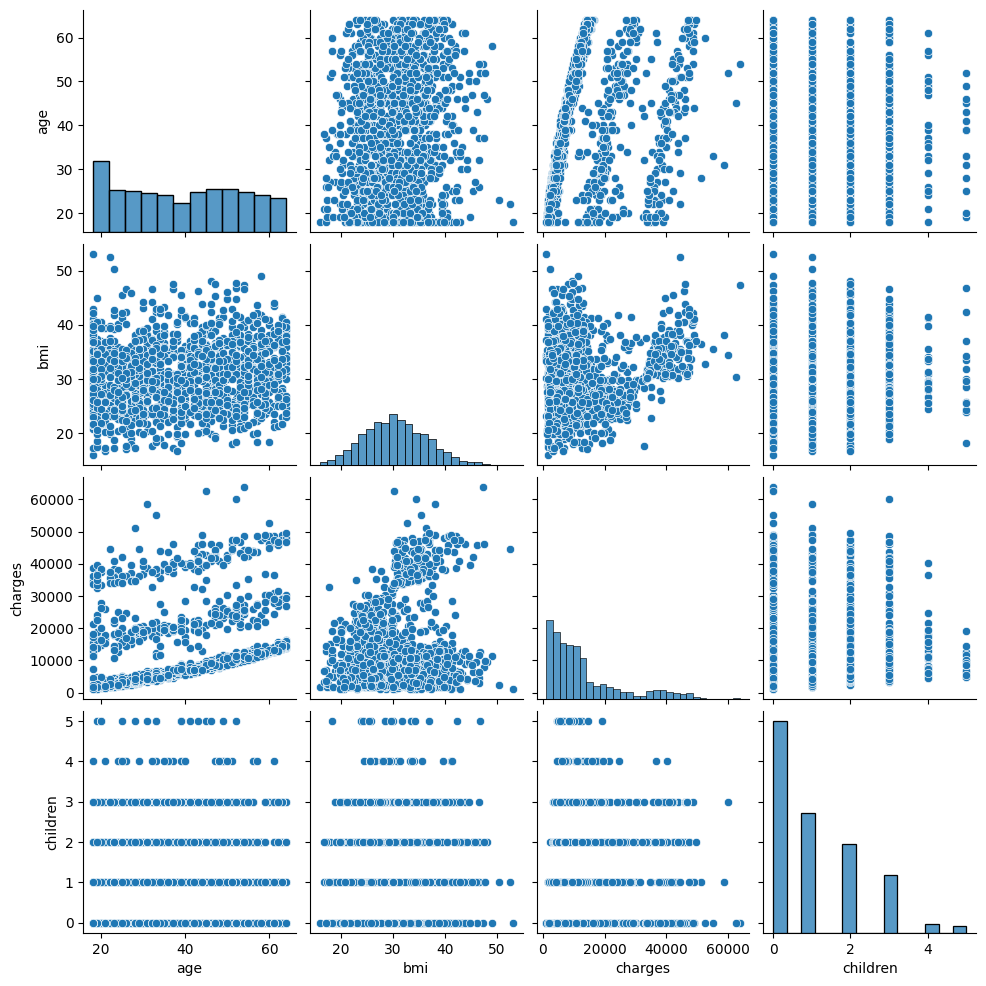

In [66]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(df[columns])
plt.show()

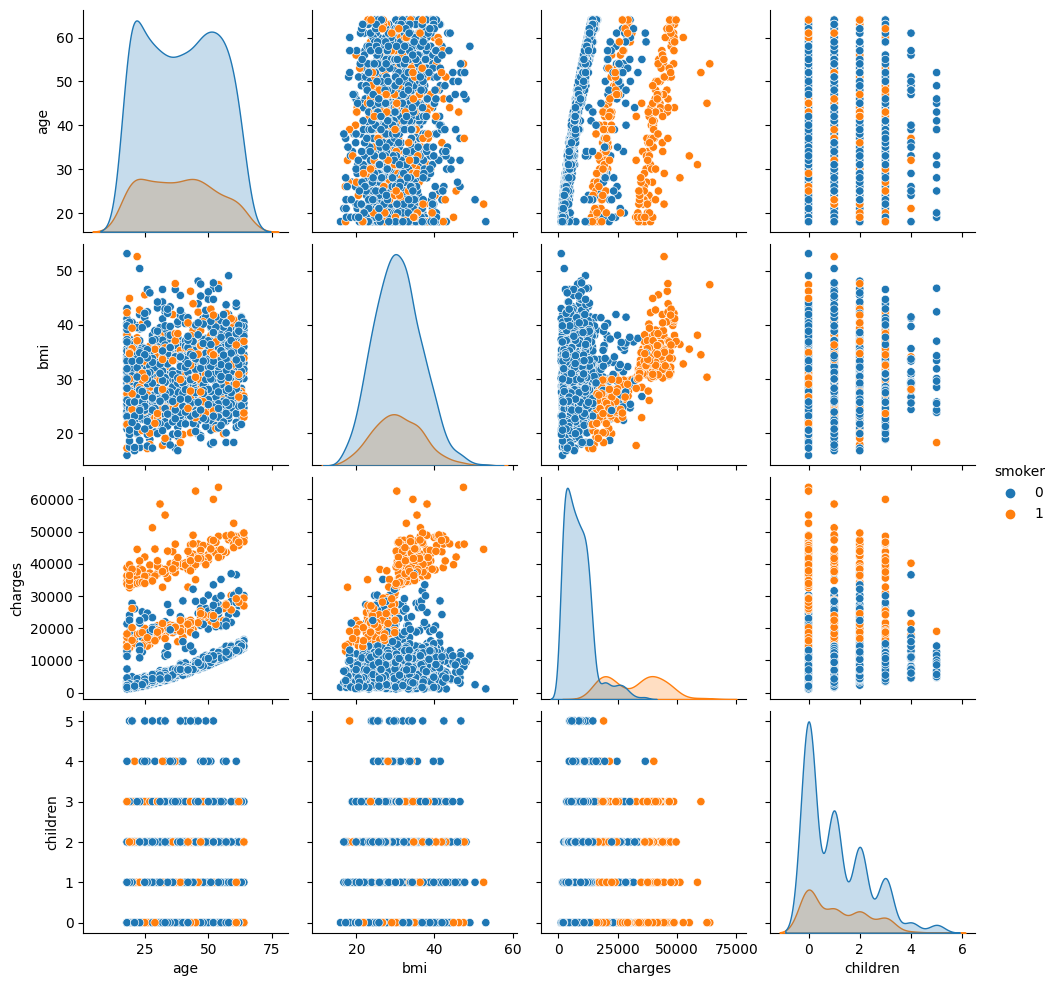

In [69]:
hue = 'smoker'
sns.pairplot(df[columns].join(df[[hue]]), hue=hue)
plt.show()

# 2.Regression Model

## 2.1 데이터 셋 분리

In [71]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

In [79]:
# 숫자형 변수
X_num = df[['age', 'bmi', 'children']].copy()
# 데이터 합치기
X_final = pd.concat([X_num, df[['sex', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast',
      'region_southwest']]], axis = 1)
# 목표 변수
y_final = df[['charges']].copy()
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state = 0)

In [80]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1069, 9) (1069, 1)
(268, 9) (268, 1)


In [81]:
X_train.head()

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
895,43,20.045,2,0,1,1.0,0.0,0.0,0.0
194,18,34.430,0,1,0,0.0,0.0,1.0,0.0
240,23,36.670,2,0,1,1.0,0.0,0.0,0.0
1256,54,27.645,1,0,0,0.0,1.0,0.0,0.0
575,58,27.170,0,0,0,0.0,1.0,0.0,0.0


## 2.2 Feature Scaling

### 2.2.1 MinMaxScaler
- 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다.


In [ ]:
mn_scaler = MinMaxScaler()
X_train_mn = mn_scaler.fit_transform(X_train)
X_test_mn = mn_scaler.transform(X_test)

### 2.2.2 StandardScaler
- 이상치가 있는 경우에는 균형 잡힌 결과를 보장하기 힘들다


In [82]:
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(float))
X_test= s_scaler.transform(X_test.astype(float))

## 2.3 Linear Regreesion

In [83]:
# fit model
lr = LinearRegression().fit(X_train,y_train)

# predict
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# 결정계수 Score 확인
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))

lr.coef_: [[ 3.46813124e+03  1.85340186e+03  6.27672945e+02 -1.31625458e+02
   9.54962659e+03  1.80776907e+17  1.81971607e+17  1.87099099e+17
   1.83595212e+17]]
lr.intercept_: [13095.24117178]
lr train score 0.748, lr test score: 0.751


## 2.4 Polynomial Regression

In [84]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly, y_final, test_size = 0.2, random_state = 0)

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(float))
X_test= sc.transform(X_test.astype(float))

# fit model
poly_lr = LinearRegression().fit(X_train,y_train)

# predict
y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

# Score 확인
print('poly train score %.3f, poly test score: %.3f' % (
poly_lr.score(X_train,y_train),
poly_lr.score(X_test, y_test)))

poly train score 0.855, poly test score: 0.838


## Support Vector Regression

In [85]:
svr = SVR(kernel='linear', C = 300)

# fit model
svr = svr.fit(X_train,y_train.values.ravel())
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Score 확인
print('svr train score %.3f, svr test score: %.3f' % (
svr.score(X_train,y_train),
svr.score(X_test, y_test)))

svr train score 0.833, svr test score: 0.816


## RandomForest Regression

In [86]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'squared_error',
                              random_state = 1,
                              n_jobs = -1)

# fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Score 확인
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train, y_train),
forest.score(X_test, y_test)))

forest train score 0.976, forest test score: 0.840


## Decision Tree Regression

In [87]:
dt = DecisionTreeRegressor(random_state=0)

# fit model
dt = dt.fit(X_train,y_train.values.ravel())
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Score 확인
print('dt train score %.3f, dt test score: %.3f' % (
dt.score(X_train,y_train),
dt.score(X_test, y_test)))

dt train score 0.998, dt test score: 0.730


In [91]:
# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 모으기
regressors = [(lr, 'Linear Regression'),
                (poly_lr, 'Polynomial Regression'),
                (svr, 'SupportVector Regression'),
                (forest, 'RandomForest Regression'),
                (dt, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 fit -> predict -> score 로 처리해서 보여주기
for reg, label in regressors:
    print(100*'-', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (
    reg.score(X_train,y_train),
    reg.score(X_test, y_test)))
    print('')
print(100*'-')

---------------------------------------------------------------------------------------------------- 

Linear Regression train score 0.855, Linear Regression test score: 0.838

---------------------------------------------------------------------------------------------------- 

Polynomial Regression train score 0.855, Polynomial Regression test score: 0.838

---------------------------------------------------------------------------------------------------- 

SupportVector Regression train score 0.833, SupportVector Regression test score: 0.816

---------------------------------------------------------------------------------------------------- 

RandomForest Regression train score 0.976, RandomForest Regression test score: 0.840

---------------------------------------------------------------------------------------------------- 

DecisionTree train score 0.998, DecisionTree test score: 0.730

-------------------------------------------------------------------------------------------